In [44]:
%matplotlib inline

import json
import numpy as np
import pandas as pd
import pylab as plt
import urllib.request

Iterate thour the pages of JSON returned by the API. Note that we are restricting the query to specific software and version.

## Get image metadata

In [16]:
url_root = 'https://neurovault.org/api/images/'

page = 100
dfs = []
while True:
    print('Page {:d}'.format(page))
    page_url = url_root + '?offset=%d' % page

    with urllib.request.urlopen(page_url) as url:
        data = json.loads(url.read().decode())
        dfs.append(pd.io.json.json_normalize(data['results']))
        if data['next'] is 'null':
            break
        else:
            page += 100

Page 100
Page 200
Page 300
Page 400
Page 500
Page 600
Page 700
Page 800
Page 900
Page 1000
Page 1100
Page 1200
Page 1300
Page 1400
Page 1500
Page 1600
Page 1700
Page 1800
Page 1900
Page 2000
Page 2100
Page 2200
Page 2300
Page 2400
Page 2500
Page 2600
Page 2700
Page 2800
Page 2900
Page 3000
Page 3100
Page 3200
Page 3300
Page 3400
Page 3500
Page 3600


KeyboardInterrupt: 

In [17]:
df_images = pd.concat(dfs, ignore_index=True)
print('{:d} images metadata returned by the query'.format(len(df_images)))
print('Image metadata fields are: \n{}'.format(df_images.keys()))

3500 images metadata returned by the query
Image metadata fields are: 
Index(['AGE', 'Age', 'CIAS', 'Filename', 'Files', 'Holdout', 'Image',
       'PainLevel', 'Picture', 'RACE', 'Rating', 'SEX', 'Sex', 'SubjectID',
       'YRS_SCH', 'add_date', 'analysis_level', 'avg_brightness', 'avg_color',
       'brain_coverage', 'brainpedia_labels', 'brainpedia_study',
       'cognitive_contrast_cogatlas', 'cognitive_contrast_cogatlas_id',
       'cognitive_paradigm_cogatlas', 'cognitive_paradigm_cogatlas_id',
       'cognitive_paradigm_description_url', 'collection', 'collection_id',
       'contrast_definition', 'contrast_definition_cogatlas', 'custom_prop',
       'data', 'data_origin', 'description', 'figure', 'file', 'file_size',
       'frac_high_saliency', 'id', 'image_type', 'is_thresholded', 'is_valid',
       'label_description_file', 'map_type', 'max_saliency', 'max_saliency_x',
       'max_saliency_y', 'modality', 'modify_date', 'name', 'nidm_results',
       'nidm_results_ttl', 'not

## Get mental tasks metadata

In [81]:
page_url = 'https://www.cognitiveatlas.org/api/v-alpha/task'

with urllib.request.urlopen(page_url) as url:
    data = json.loads(url.read().decode())
    df_tasks = pd.io.json.json_normalize(data)

In [19]:
print('{:d} tasks metadata returned by the query'.format(len(df_tasks)))
print('Tasks fields are: \n{}'.format(df_tasks.keys()))

744 tasks metadata returned by the query
Tasks fields are: 
Index(['alias', 'creation_time', 'def_event_stamp', 'def_id', 'def_id_user',
       'definition_text', 'event_stamp', 'id', 'id_concept_class', 'id_user',
       'last_updated', 'name', 'review_status'],
      dtype='object')


## Matching tasks IDs with image metadata

In [28]:
task_ids = df_tasks.id

In [63]:
n_task_ids = len(set(task_ids))
assert n_task_ids == len(task_ids)
print('There are {:d} unique mental task IDs'.format(n_task_ids))

There are 744 unique mental task IDs


In [ ]:
paradigm_ids = df_images.cognitive_paradigm_cogatlas_id  # Some are None or NaN
contrast_ids = df_images.cognitive_contrast_cogatlas_id  # Some are None or NaN
paradigm_ids = paradigm_ids.where((pd.notnull(paradigm_ids)), None) # Bring the NaN to None
contrast_ids = contrast_ids.where((pd.notnull(contrast_ids)), None)

In [70]:
print(np.asarray(paradigm_ids))

['trm_4e8dd3831f0cc' 'trm_4e8dd3831f0cc' 'trm_4ebc9d2e397f2' ... None None
 None]


In [86]:
mask_paradigm_ids = ~np.equal(paradigm_ids, None)
print('{:d}/{:d} images have paradigm ID '.format(sum(mask_paradigm_ids), len(mask_paradigm_ids)))
unique_paradigm_ids = set(paradigm_ids[mask_paradigm_ids])
print('There are {:d} unique task ID in paradigm metadata'.format(len(unique_paradigm_ids)))

1802/3500 images have paradigm ID 
There are 109 unique task ID in paradigm metadata


In [85]:
mask_contrast_ids = ~np.equal(contrast_ids, None)
print('{:d}/{:d} images have contrast ID '.format(sum(mask_contrast_ids), len(mask_contrast_ids)))
unique_contrast_ids = set(contrast_ids[mask_contrast_ids])
print('There are {:d} unique task ID in contrast metadata'.format(len(unique_contrast_ids)))

296/3500 images have contrast ID 
There are 114 unique task ID in contrast metadata


In [79]:
n_intersection = len(set(task_ids) & set(unique_paradigm_ids))
print('Intersection between mental task IDs and paradigm IDs: {:d}'.format(n_intersection))

Intersection between mental task IDs and paradigm IDs: 108


In [80]:
n_intersection = len(set(task_ids) & set(unique_contrast_ids))
print('Intersection between mental task IDs and contrast IDs: {:d}'.format(n_intersection))

Intersection between mental task IDs and contrast IDs: 0


Thus we will work only with paradigm IDs.

## Distribution of mental task IDs in the image metadata 'paradigm'

In [92]:
unique, counts = np.unique(paradigm_ids[mask_paradigm_ids], return_counts=True)
task_id_to_count = dict(zip(unique, counts))

In [93]:
task_id_to_name = {task[1]['id']:task[1]['name'] for task in df_task.iterrows()}

In [94]:
task_name_to_count = {task_id_to_name[task_id]: task_id_to_count[task_id] 
                      for task_id in task_id_to_name
                      if task_id in set(task_ids) & set(unique_paradigm_ids)}

In [95]:
task_name_to_count

{'2-stage decision task': 1,
 '2nd-order rule acquisition': 6,
 'Bistable percept paradigm': 12,
 'Counting/Calculation': 7,
 'Covert verb generation task': 2,
 'Emotion Regulation Task': 1,
 'Eriksen flanker task': 6,
 'Expressive Vocabulary Test': 1,
 'Incidental encoding task': 26,
 'International Affective Picture System': 446,
 'Landmark task': 5,
 'Listening and reading task': 5,
 'NPU-threat test': 3,
 'Overt word repetition': 1,
 'Penn continuous performance task': 1,
 'Probabilistic classification task': 11,
 "Raven's Advanced Progressive Matrices": 71,
 'Sentence/nonword language localizer': 33,
 'Simon task': 8,
 'Tapping task': 3,
 'aberrant behavior checklist - community': 4,
 'abstract/concrete judgment: bilingual': 23,
 'abstract/concrete task': 7,
 'action imitation task': 2,
 'action observation task': 10,
 'acupuncture task': 1,
 'adolescent symptom inventory': 1,
 'analogical reasoning task': 50,
 'associative memory encoding task': 4,
 'auditory scene perception': 7

In [101]:
#sum(task_name_to_count.values()) 
sum(mask_paradigm_ids)

1802

<Container object of 108 artists>

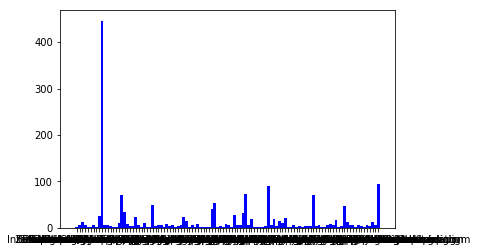

In [97]:
plt.bar(task_name_to_count.keys(), task_name_to_count.values(), width=1, color='b')
#plt.xticks(rotation=90)

TypeError: unsupported operand type(s) for +: 'int' and 'dict_values'

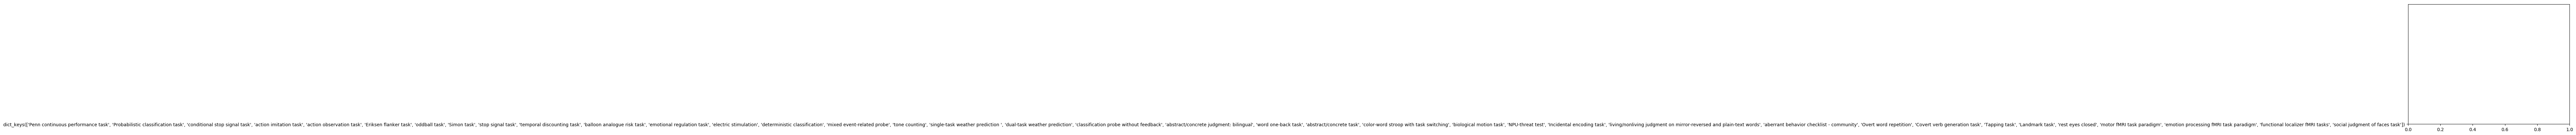

In [94]:
plt.rcdefaults()

fig, ax = plt.subplots()
ax.barh(task_name_to_count.keys(), task_name_to_count.values(), color='b')
#plt.xticks(rotation=90)

In [81]:
task_id_to_name

{'trm_4a3fd79d09b6d': 'backward masking',
 'trm_4a3fd79d0b3d7': 'trace conditioning',
 'trm_4af89b3a925ca': 'Vandenberg & Kuse Tasks',
 'trm_4b1968619b00b': 'color-word stroop task',
 'trm_4b4a537644d76': 'Penn continuous performance task',
 'trm_4b65e5e2ab3ca': 'word-picture verification task',
 'trm_4b7497a289534': 'block design test',
 'trm_4b749b8829eee': 'embedded figures test',
 'trm_4b75ea4ddd896': 'same-different task',
 'trm_4b843655d5d75': 'chimeric animal Stroop task',
 'trm_4b86c2e871b14': 'rapid automatized naming test',
 'trm_4b86c473a7166': 'underlining test',
 'trm_4b86c55f3d5df': 'WISC-R Mazes',
 'trm_4b86dbcd8ff78': 'rapid serial object transformation',
 'trm_4b94affc43245': 'Wechsler Abbreviated Scale of Intelligence',
 'trm_4b94b12bf0eb2': 'Wechsler Memory Scale Fourth Edition',
 'trm_4b9568b2865c2': 'MicroCog',
 'trm_4c3e0a9576c3b': 'letter number sequencing',
 'trm_4c3e0add96550': 'oculomotor delayed response',
 'trm_4c40d10cd776e': 'operation span task',
 'trm_4c

In [ ]:
import networkx # pour storer des graphs